In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For inline plotting in Jupyter Notebook
%matplotlib inline

# Load the CSV file (make sure Prompt1AccountLevel.csv is in the same folder as this notebook)
df = pd.read_csv("Prompt1AccountLevel.csv")

# Remove any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Preview the data
df.head()


,Season,AccountNumber,SingleGameTickets,PartialPlanTickets,GroupTickets,STM,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,SocialMediaEngagement
0,2023,1,0,0,0,0,$467.00,0,F,12.0,872.0,Low
1,2023,2,2,0,0,0,$116.00,1,A,47.0,485.0,Low
2,2023,3,3,0,0,0,$107.00,1,B,6.0,896.0,Low
3,2023,4,0,0,3,0,$27.00,1,C,3.0,467.0,High
4,2023,5,0,0,2,0,$14.00,1,A,4.0,582.0,Medium


In [3]:
# Clean the AvgSpend column: remove "$" and commas then convert to float
df['AvgSpend'] = pd.to_numeric(df['AvgSpend'].replace('[\$,]', '', regex=True), errors='coerce')

# Convert other columns to numeric as needed
numeric_cols = ["SingleGameTickets", "PartialPlanTickets", "GroupTickets", "STM", 
                "GamesAttended", "DistanceToArena", "BasketballPropensity"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check that the columns are correctly formatted
print(df.dtypes)


Season                     int64
AccountNumber              int64
SingleGameTickets          int64
PartialPlanTickets         int64
GroupTickets               int64
STM                        int64
AvgSpend                 float64
GamesAttended              int64
FanSegment                object
DistanceToArena          float64
BasketballPropensity     float64
SocialMediaEngagement     object
dtype: object


In [4]:
# Drop identifier columns that are not meaningful for PCA
df_reduced = df.drop(columns=["Season", "AccountNumber"])

# One-hot encode the categorical columns (drop_first to avoid dummy variable trap)
dummies = pd.get_dummies(df_reduced[['FanSegment', 'SocialMediaEngagement']], drop_first=True)

# Drop the original categorical columns from the dataframe
df_reduced = df_reduced.drop(columns=['FanSegment', 'SocialMediaEngagement'])

# Concatenate the numeric data with the dummy variables
data_for_pca = pd.concat([df_reduced, dummies], axis=1)

# Drop rows with any missing values (PCA cannot handle NaNs)
data_for_pca = data_for_pca.dropna()

# Optionally, inspect the first few rows
data_for_pca.head()


,SingleGameTickets,PartialPlanTickets,GroupTickets,STM,AvgSpend,GamesAttended,DistanceToArena,BasketballPropensity,FanSegment_B,FanSegment_C,FanSegment_D,FanSegment_E,FanSegment_F,FanSegment_G,FanSegment_Limited Data,SocialMediaEngagement_Low,SocialMediaEngagement_Medium
0,0,0,0,0,467.0,0,12.0,872.0,False,False,False,False,True,False,False,True,False
1,2,0,0,0,116.0,1,47.0,485.0,False,False,False,False,False,False,False,True,False
2,3,0,0,0,107.0,1,6.0,896.0,True,False,False,False,False,False,False,True,False
3,0,0,3,0,27.0,1,3.0,467.0,False,True,False,False,False,False,False,False,False
4,0,0,2,0,14.0,1,4.0,582.0,False,False,False,False,False,False,False,False,True


In [5]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_pca)

# Run PCA; here we do not preset the number of components
pca = PCA()
pca_result = pca.fit_transform(data_scaled)

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio for each component:\n", explained_variance)


Explained Variance Ratio for each component:
 [0.13660432 0.09295389 0.08069166 0.07308611 0.0659755  0.06518616
 0.06365978 0.06096673 0.06071836 0.05888378 0.05581213 0.04911395
 0.04498407 0.03293309 0.02471434 0.01939768 0.01431844]


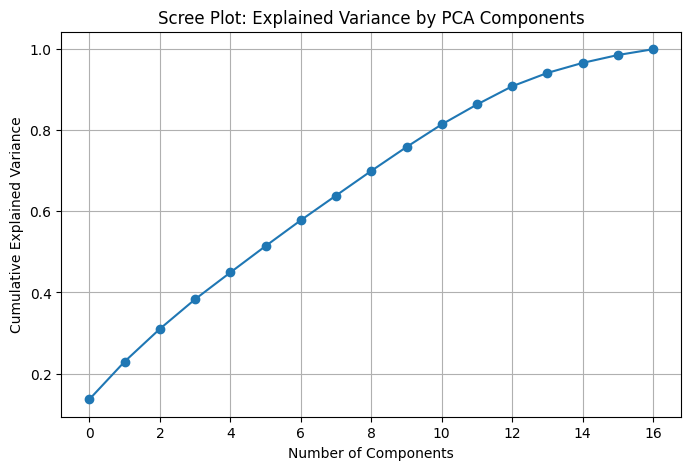

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: Explained Variance by PCA Components')
plt.grid(True)
plt.show()


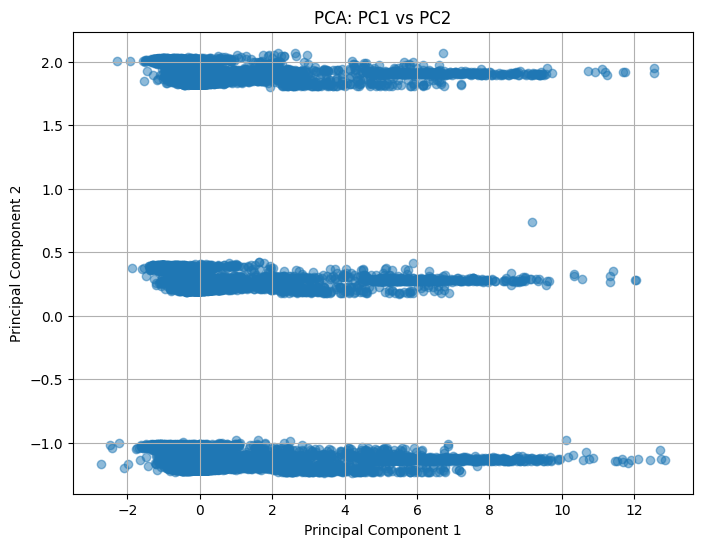

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2')
plt.grid(True)
plt.show()


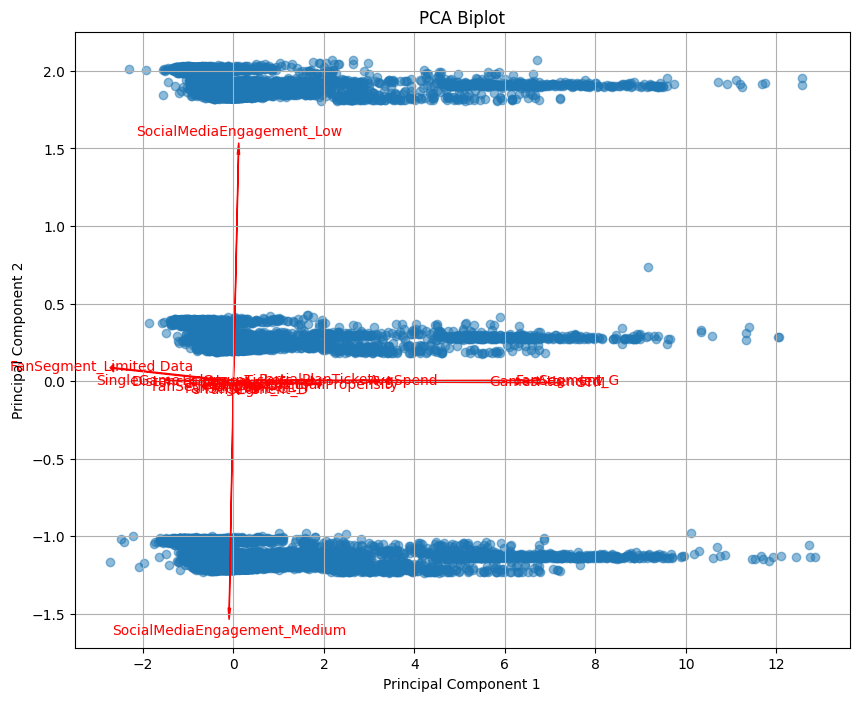

In [8]:
plt.figure(figsize=(10, 8))
# Plot the projected data points
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

# Get feature names from the prepared data
features = data_for_pca.columns
# Scale factor for the arrows for better visualization
scale_x = max(pca_result[:,0])
scale_y = max(pca_result[:,1])

# Plot the loadings (arrow vectors)
for i, feature in enumerate(features):
    # The loadings are in the columns of pca.components_.T
    plt.arrow(0, 0, pca.components_[0, i]*scale_x, pca.components_[1, i]*scale_y,
              color='r', width=0.005, head_width=0.05)
    plt.text(pca.components_[0, i]*scale_x*1.1, pca.components_[1, i]*scale_y*1.1,
             feature, color='r', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot')
plt.grid(True)
plt.show()
